In [20]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import os
import datetime
pd.options.display.float_format = '{:.1f}'.format
pd.set_option('display.max_columns', 500)
from __future__ import print_function
import math
import csv
import glob

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.sandbox.regression.predstd import wls_prediction_std


# visualization
from IPython import display
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import cm
%matplotlib inline

#sentiment analysis
from textblob import TextBlob
import re
import nltk
from nltk.corpus import stopwords


# technical analaysis  
import talib

# machine learning
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset
tf.logging.set_verbosity(tf.logging.ERROR)
from sklearn.preprocessing import MinMaxScaler

## data import

In [2]:
tweet_df = pd.read_csv('data/processed_tweet_data.csv')

In [10]:
#tweet_df.head()
tweet_df = tweet_df.drop(columns='Unnamed: 0')

In [11]:
tweet_df.head()

,date,tweet_len,sentiment_score,pos_sentiment_tweet,neutral_sentiment_tweet,neg_sentiment_tweet,pos-neg,neg-plus-neutral,pos-neg-plusNeutral,posNeg-plusNeutral,signal
0,2014-12-08,12297.0,28.0,56.0,58.0,28.0,28.0,86.0,-30.0,-30.0,-1
1,2014-12-10,14389.0,40.0,67.0,70.0,27.0,40.0,97.0,-30.0,-30.0,-1
2,2014-12-13,14507.0,40.0,67.0,71.0,27.0,40.0,98.0,-31.0,-31.0,-1
3,2014-12-17,8227.0,38.0,42.0,44.0,4.0,38.0,48.0,-6.0,-6.0,-1
4,2014-12-18,7240.0,28.0,31.0,44.0,3.0,28.0,47.0,-16.0,-16.0,-1


In [3]:
price_df = pd.read_csv('data/processed_btc_price_data_2014-12-01_to_2018-11-11.csv')

In [13]:
price_df = price_df.drop(columns='Unnamed: 0')
price_df.head()

,date,Close
0,2014-12-01,335.0
1,2014-12-02,377.9
2,2014-12-03,377.7
3,2014-12-05,378.0
4,2014-12-08,375.0


## Merge: price and tweet

In [14]:
price_tweet_df = (price_df.merge(tweet_df, on='date'))

In [15]:
price_tweet_df.describe()

,Close,tweet_len,sentiment_score,pos_sentiment_tweet,neutral_sentiment_tweet,neg_sentiment_tweet,pos-neg,neg-plus-neutral,pos-neg-plusNeutral,posNeg-plusNeutral,signal
count,1021.0,1021.0,1021.0,1021.0,1021.0,1021.0,1021.0,1021.0,1021.0,1021.0,1021.0
mean,3976.8,491148.0,982.4,1432.6,2770.5,450.3,982.4,3220.7,-1788.1,-1788.1,-0.9
std,4103.0,1721967.1,2933.3,4594.4,9750.4,1707.6,2933.3,11424.8,6849.7,6849.7,0.4
min,199.8,4002.0,3.0,14.0,18.0,0.0,3.0,21.0,-129536.0,-129536.0,-1.0
25%,457.6,11994.0,34.0,44.0,71.0,8.0,34.0,80.0,-1107.0,-1107.0,-1.0
50%,2264.0,27819.0,72.0,94.0,175.0,26.0,72.0,197.0,-113.0,-113.0,-1.0
75%,6701.1,355232.0,708.0,982.0,1730.0,301.0,708.0,1998.0,-36.0,-36.0,-1.0
max,19419.9,33193074.0,51388.0,85670.0,180924.0,34282.0,51388.0,215206.0,35.0,35.0,1.0


In [16]:
price_tweet_df.head()

,date,Close,tweet_len,sentiment_score,pos_sentiment_tweet,neutral_sentiment_tweet,neg_sentiment_tweet,pos-neg,neg-plus-neutral,pos-neg-plusNeutral,posNeg-plusNeutral,signal
0,2014-12-08,375.0,12297.0,28.0,56.0,58.0,28.0,28.0,86.0,-30.0,-30.0,-1
1,2014-12-18,340.0,7240.0,28.0,31.0,44.0,3.0,28.0,47.0,-16.0,-16.0,-1
2,2015-01-12,260.0,10972.0,26.0,34.0,77.0,8.0,26.0,85.0,-51.0,-51.0,-1
3,2015-01-15,207.6,10526.0,30.0,40.0,68.0,10.0,30.0,78.0,-38.0,-38.0,-1
4,2015-01-16,203.0,7033.0,9.0,20.0,45.0,11.0,9.0,56.0,-36.0,-36.0,-1


In [18]:
len(price_tweet_df)

1021

## OLS Regression

In [17]:
price_tweet_model = ols("""pos_sentiment_tweet ~ Close""", data=price_tweet_df).fit()

price_tweet_model_summary = price_tweet_model.summary()
price_tweet_model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     pos_sentiment_tweet   R-squared:                       0.112
Model:                             OLS   Adj. R-squared:                  0.111
Method:                  Least Squares   F-statistic:                     128.7
Date:                 Thu, 24 Jan 2019   Prob (F-statistic):           3.51e-28
Time:                         13:41:13   Log-Likelihood:                -9997.2
No. Observations:                 1021   AIC:                         2.000e+04
Df Residuals:                     1019   BIC:                         2.001e+04
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -58.7121    188.813     -0.311      0.756    -429.219     311.795
Close          0.3750      0.033     11.346      0.000       0.310       0.440
==============================================================================
Omnibus:                     1732.420   Durbin-Watson:                   0.236
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1156823.713
Skew:                          10.936   Prob(JB):                         0.00
Kurtosis:                     166.445   Cond. No.                     7.96e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.96e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

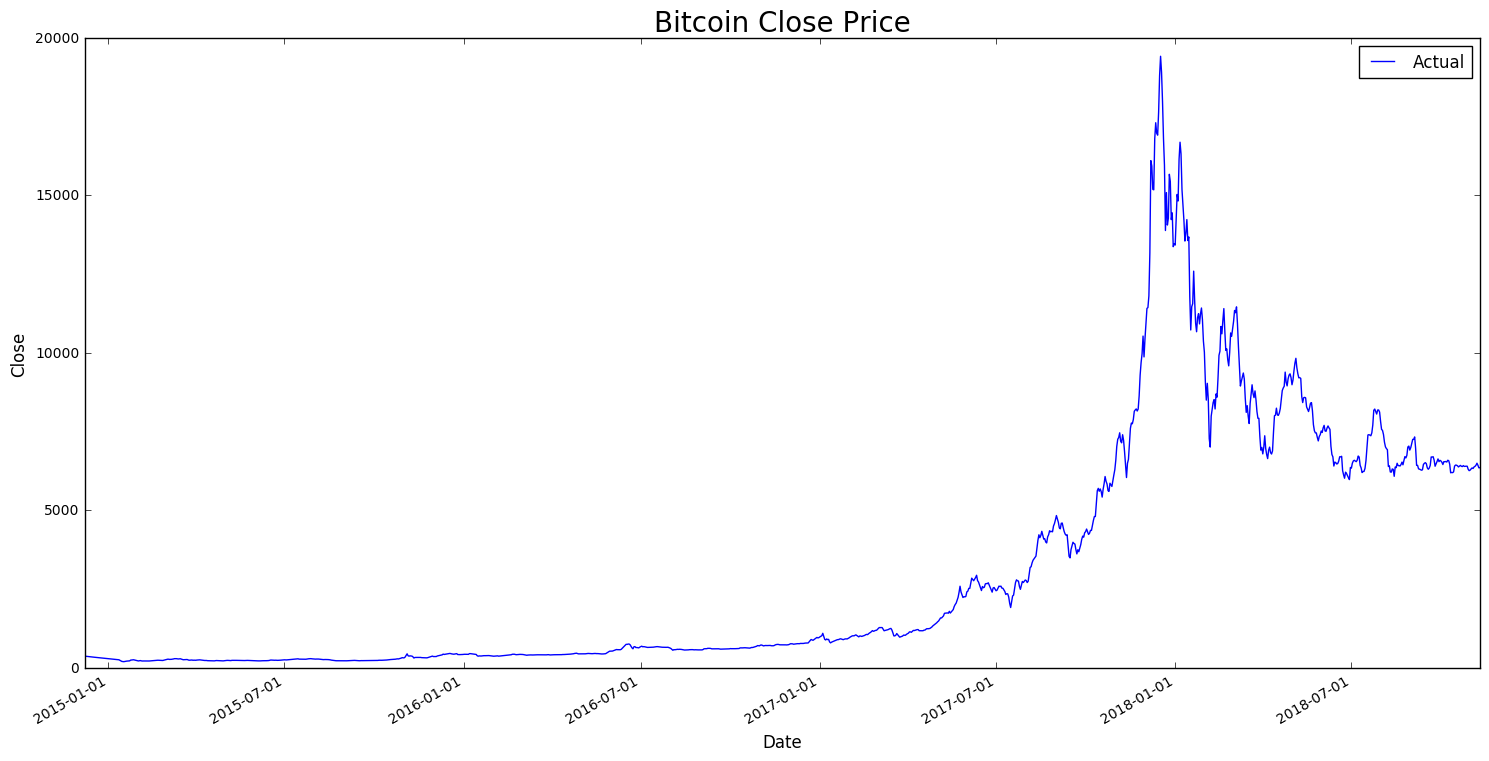

In [21]:
#preproces date col
dates_list_actual = list(price_tweet_df['date'])
dates_list_formatted_actual = [datetime.datetime.strptime(d,'%Y-%m-%d').date() for d in dates_list_actual]

# dates_list_training = list(price_tweet_df_training['date'])
# dates_list_formatted_training = [datetime.datetime.strptime(d,'%Y-%m-%d').date() for d in dates_list_training]

#dates_list_test = list(price_tweet_df['date'].tail(212))
#dates_list_formatted_test = [datetime.datetime.strptime(d,'%Y-%m-%d').date() for d in dates_list_test]

# price visualization
plt.figure(figsize = (18,9))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.plot(dates_list_formatted_actual, price_tweet_df['Close'], color='b', label='Actual')
#plt.plot(dates_list_formatted_training, predictions, color='red', label='Training')
#plt.plot(dates_list_formatted_test, test_predictions, color='red', label='Test-Predicted')

plt.xlabel('Date',fontsize=12)
plt.ylabel('Close',fontsize=12)
plt.gcf().autofmt_xdate()
plt.title('Bitcoin Close Price',fontsize=20)
plt.ylim(-1,20000)
plt.legend()

In [ ]:
# Sentiment visualization
plt.figure(figsize = (18,9))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
#plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=0))

plt.plot(dates_list_formatted, price_tweet_df['sentiment'])
plt.xlabel('Date',fontsize=12)
plt.ylabel('sentiment',fontsize=12)
plt.gcf().autofmt_xdate()
plt.title('sentiment',fontsize=20)

## tensorflow: LinearRegressor

In [22]:
# training test split
price_tweet_df_training = price_tweet_df[:800]
price_tweet_df_test = price_tweet_df[800:]


In [32]:
len(price_tweet_df_test)

221

In [23]:
def preprocess_features(price_tweet_df):
    """Prepares input features from price_tweet_dfdata set.

  Args:
    price_tweet_df: A Pandas DataFrame expected to contain feature data
  Returns:
    A DataFrame that contains the features to be used for the model.
  """
    selected_features = price_tweet_df[["pos_sentiment_tweet"]]
    processed_features = selected_features.copy()
    
    return processed_features

def preprocess_targets(price_tweet_df):
    """Prepares target features (i.e., labels) from price_tweet_df data set.

  Args:
    price_tweet_df: A Pandas DataFrame expected to contain target data
     
  Returns:
    A DataFrame that contains the target feature.
  """
    output_targets = pd.DataFrame()
    output_targets["Close"] = price_tweet_df["Close"]
    
    return output_targets

In [26]:
def my_input_fn(features, targets, batch_size=1, shuffle=False, num_epochs=None):
    """Trains a linear regression model of one feature.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
    
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
        ds = ds.shuffle(buffer_size=10000)
            
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [24]:
def train_model(learning_rate, steps, batch_size, input_feature="pos_sentiment_tweet"):
    """Trains a linear regression model of one feature.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    input_feature: A `string` specifying a column from `price_tweet_df`
      to use as input feature.
  """
    periods = 10
    steps_per_period = steps / periods
    
    my_feature = input_feature
    my_feature_data = price_tweet_df_training[[my_feature]]
    my_label = "Close"
    targets = price_tweet_df_training[my_label]
    
    # Create feature columns.
    feature_columns = [tf.feature_column.numeric_column(my_feature)]
    
    # Create input functions.
    training_input_fn = lambda:my_input_fn(my_feature_data, targets, batch_size=batch_size)
    prediction_input_fn = lambda: my_input_fn(my_feature_data, targets, num_epochs=1, shuffle=False)
    
    # Create a linear regressor object.
    my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=feature_columns,
      optimizer=my_optimizer
  )
    # Set up to plot the state of our model's line each period.
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    plt.title("Learned Line by Period")
    plt.ylabel(my_label)
    plt.xlabel(my_feature)
    sample = price_tweet_df.sample(n=300)
    plt.scatter(sample[my_feature], sample[my_label])
    colors = [cm.coolwarm(x) for x in np.linspace(-1, 1, periods)]
    
    # Train the model, but do so inside a loop so that we can periodically assess
    # loss metrics.
    print("Training model...")
    print("RMSE (on training data):")
    root_mean_squared_errors = []
    for period in range (0, periods):
        # Train the model, starting from the prior state.
        linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
        )
        
        # Take a break and compute predictions.
        predictions = linear_regressor.predict(input_fn=prediction_input_fn)
        predictions = np.array([item['predictions'][0] for item in predictions])
        
        # Compute loss.
        root_mean_squared_error = math.sqrt(metrics.mean_squared_error(predictions, targets))
        
        # Occasionally print the current loss.
        print("  period %02d : %0.2f" % (period, root_mean_squared_error))
        # Add the loss metrics from this period to our list.
        root_mean_squared_errors.append(root_mean_squared_error)
        
        # Finally, track the weights and biases over time.
        # Apply some math to ensure that the data and line are plotted neatly.
        y_extents = np.array([0, sample[my_label].max()])
        
        weight = linear_regressor.get_variable_value('linear/linear_model/%s/weights' % input_feature)[0]
        bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')
        
        x_extents = (y_extents - bias) / weight
        x_extents = np.maximum(np.minimum(x_extents,
                                  sample[my_feature].max()),
                           sample[my_feature].min())
        
        y_extents = weight * x_extents + bias
        plt.plot(x_extents, y_extents, color=colors[period]) 
    
    print("Model training finished.")
    
    # Output a graph of loss metrics over periods.
    plt.subplot(1, 2, 2)
    plt.ylabel('RMSE')
    plt.xlabel('Periods')
    plt.title("Root Mean Squared Error vs. Periods")
    plt.tight_layout()
    plt.plot(root_mean_squared_errors)
    
    # Output a table with calibration data.
    calibration_data_final = pd.DataFrame()
    calibration_data_final["predictions"] = pd.Series(predictions)
    calibration_data_final["targets"] = pd.Series(targets)
    display.display(calibration_data_final.describe())
    
    #preproces date col
    dates_list_actual = list(price_tweet_df['date'])
    dates_list_formatted_actual = [datetime.datetime.strptime(d,'%Y-%m-%d').date() for d in dates_list_actual]

    dates_list_training = list(price_tweet_df_training['date'])
    dates_list_formatted_training = [datetime.datetime.strptime(d,'%Y-%m-%d').date() for d in dates_list_training]

    #dates_list_test = list(price_tweet_df['date'].tail(212))
    #dates_list_formatted_test = [datetime.datetime.strptime(d,'%Y-%m-%d').date() for d in dates_list_test]

    # price visualization
    plt.figure(figsize = (18,9))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    #plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=0))

    plt.plot(dates_list_formatted_actual, price_tweet_df['Close'], color='b', label='Actual')
    plt.plot(dates_list_formatted_training, predictions, color='red', label='Training')
    #plt.plot(dates_list_formatted_test, test_predictions, color='red', label='Test-Predicted')

    plt.xlabel('Date',fontsize=12)
    plt.ylabel('Close',fontsize=12)
    plt.gcf().autofmt_xdate()
    plt.title('Bitcoin Close Price',fontsize=20)
    plt.ylim(-1,20000)
    plt.legend()
    
    print("Final RMSE (on training data): %0.2f" % root_mean_squared_error)
    
    return linear_regressor

Training model...
RMSE (on training data):
  period 00 : 59632.00
  period 01 : 59540.34
  period 02 : 59446.13
  period 03 : 59351.34
  period 04 : 59256.81
  period 05 : 59162.88
  period 06 : 59069.66
  period 07 : 58977.20
  period 08 : 58885.50
  period 09 : 58794.53
Model training finished.


,predictions,targets
count,800.0,800.0
mean,11187.5,3111.8
std,59389.7,4217.5
min,174.1,199.8
25%,479.7,419.1
50%,738.3,893.7
75%,2263.5,4256.8
max,1007040.0,19419.9


Final RMSE (on training data): 58794.53


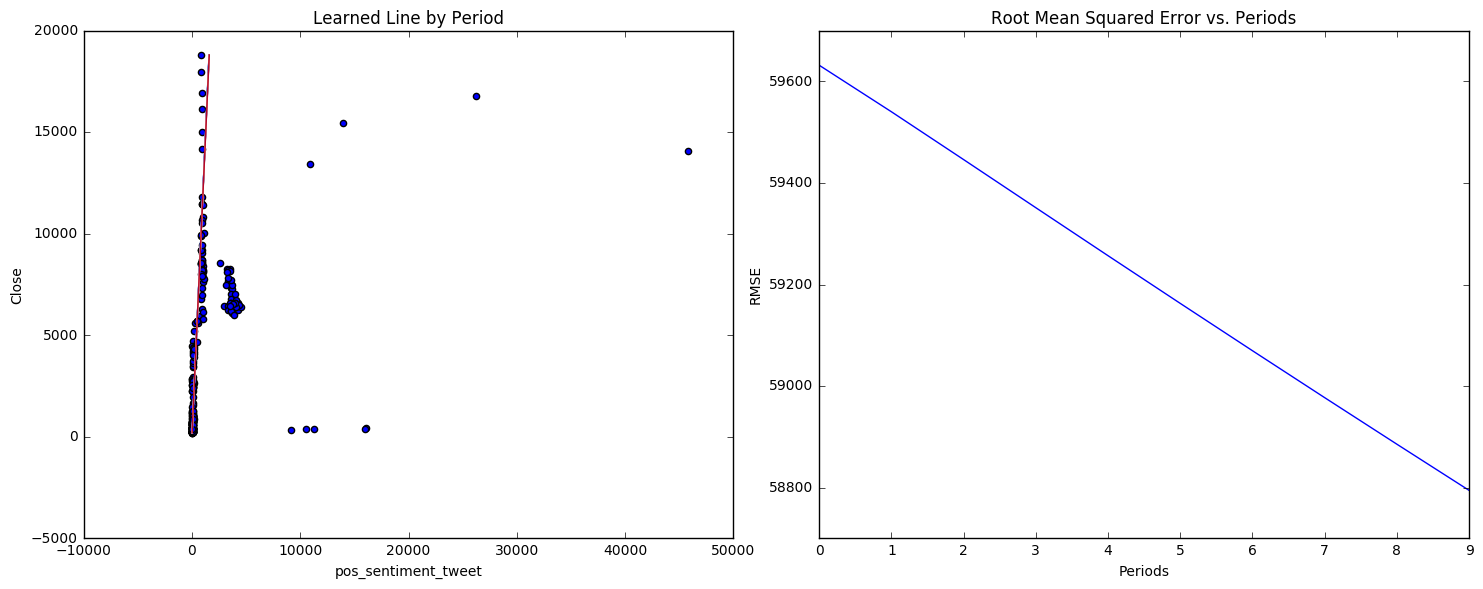

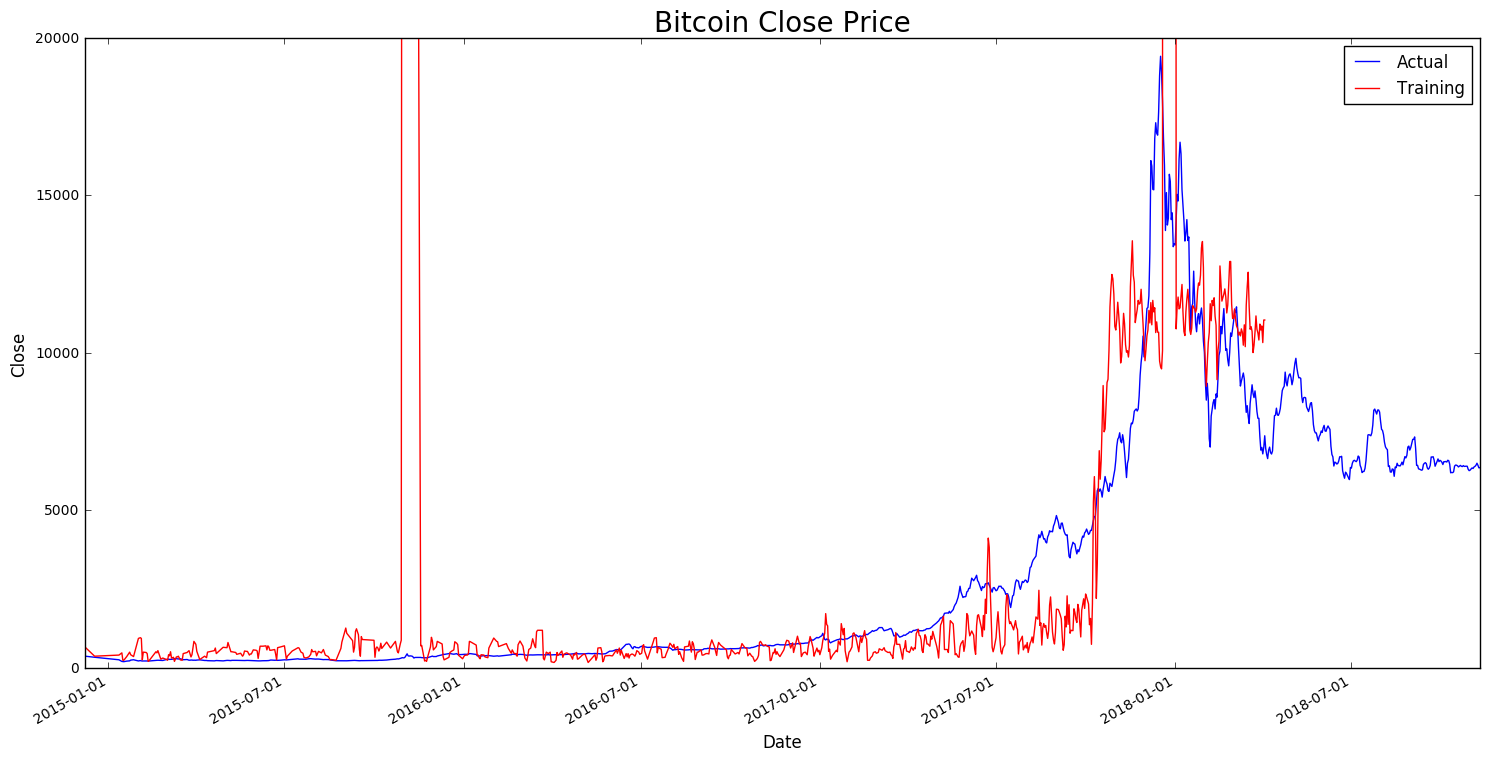

In [27]:
linear_regressor = train_model(
    learning_rate=0.2,
    steps=500,
    batch_size=5)

## Evaluate on Test data

In [28]:
price_tweet_df_test = price_tweet_df[800:]

test_examples = preprocess_features(price_tweet_df_test)
test_targets = preprocess_targets(price_tweet_df_test)

predict_test_input_fn = lambda: my_input_fn(
    test_examples, 
    test_targets['Close'], 
    num_epochs=1, 
    shuffle=False)

test_predictions = linear_regressor.predict(input_fn=predict_test_input_fn)
test_predictions = np.array([item['predictions'][0] for item in test_predictions])

root_mean_squared_error = math.sqrt(metrics.mean_squared_error(test_predictions, test_targets))
print("Final RMSE (on test data): %0.2f" % root_mean_squared_error)

Final RMSE (on test data): 33260.55


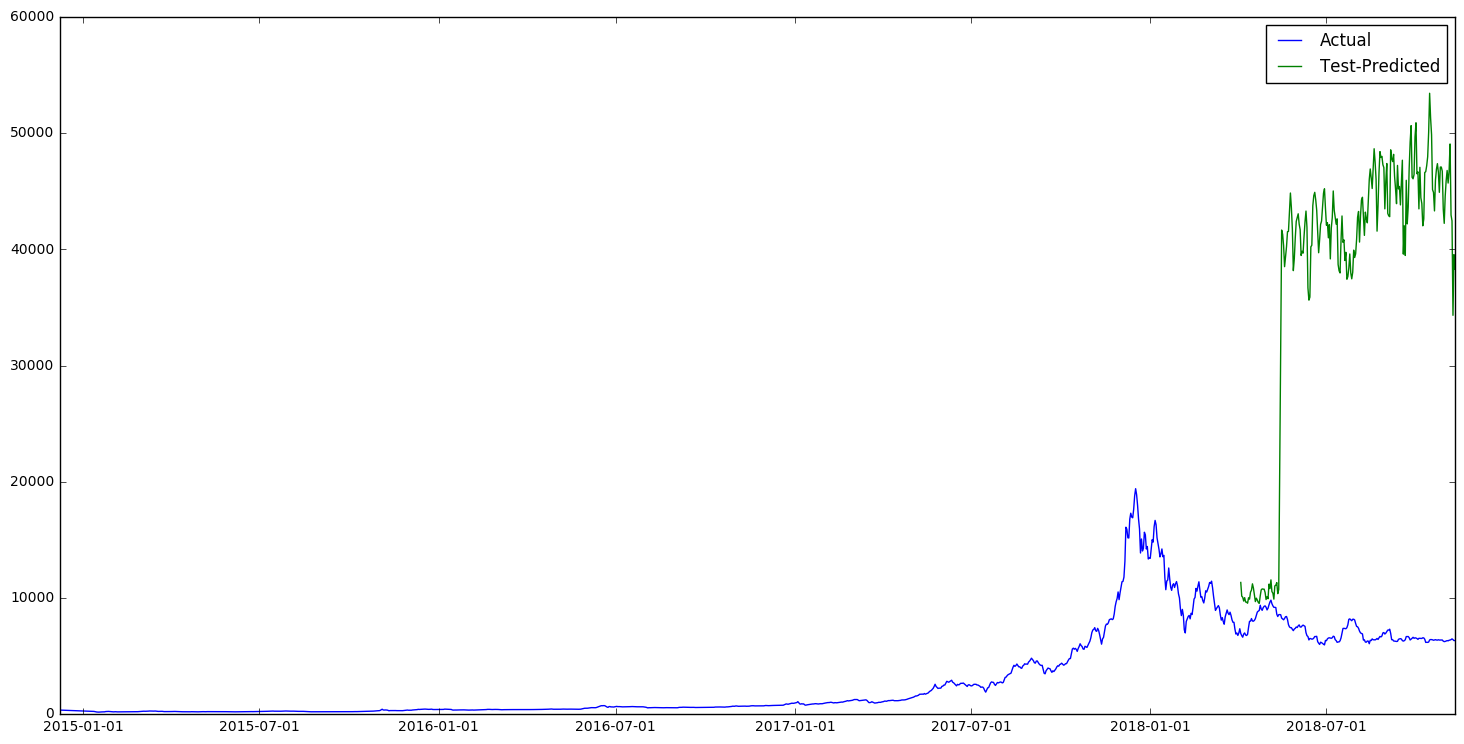

In [33]:
#preproces date col
dates_list_actual = list(price_tweet_df['date'])
dates_list_formatted_actual = [datetime.datetime.strptime(d,'%Y-%m-%d').date() for d in dates_list_actual]

# dates_list_training = list(price_tweet_df_training['date'])
# dates_list_formatted_training = [datetime.datetime.strptime(d,'%Y-%m-%d').date() for d in dates_list_training]

dates_list_test = list(price_tweet_df_test['date'].tail(221))
dates_list_formatted_test = [datetime.datetime.strptime(d,'%Y-%m-%d').date() for d in dates_list_test]

# price visualization
plt.figure(figsize = (18,9))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.plot(dates_list_formatted_actual, price_tweet_df['Close'], color='b', label='Actual')
#plt.plot(dates_list_formatted_training, predictions, color='red', label='Training')
plt.plot(dates_list_formatted_test, test_predictions, color='green', label='Test-Predicted')
plt.legend()

In [4]:
#type(price_df['date'])
dates_list = list(price_df['date'])
#dates_list[0:10]
#type(price_df['date'][0])
dates_list_formatted = [datetime.datetime.strptime(d,'%Y-%m-%d').date() for d in dates_list]


# price visualization
plt.figure(figsize = (18,9))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
#plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=0))

plt.plot(dates_list_formatted, price_df['Close'])
plt.xlabel('Date',fontsize=12)
plt.ylabel('Close Price',fontsize=12)
plt.gcf().autofmt_xdate()
plt.title('Bitcoin Close Price',fontsize=20)